# This notebook uses already prepared "final_data_with_sentiment.csv" for Advance feature engineering

## Imports & Setup

In [2]:
import os
import numpy as np
import pandas as pd
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"
DATA_PATH = os.path.join(PROJECT_PATH, "processed_data", "final_data_with_sentiment.csv")

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
display(df.head(3))

# ----------------------------
# Column Categories
# ----------------------------

# Identifiers
ID_COL = "player_id"
SEASON_COL = "season"
IDENTIFIERS = [ID_COL, SEASON_COL, "player_name", "player_name_norm", "last_season"]

# Target
TARGET_COL = "max_market_value"

# Market Value
MARKET_COLS = ["avg_market_value", "min_market_value", "highest_market_value_in_eur"]

# Transfers
TRANSFER_COLS = ["num_transfers", "avg_transfer_fee", "last_transfer_fee",
                 "avg_transfer_premium", "last_transfer_premium",
                 "last_transfer_club_to", "last_transfer_club_from"]

# Performance
PERFORMANCE_COLS = ["total_goals", "total_assists", "total_minutes_played",
                    "total_yellow_cards", "total_red_cards", "matches_played"]

# Injuries
INJURY_COLS = ["injury_days", "matches_missed", "injury_count",
               "avg_rating_before_injury", "avg_rating_after_injury", "rating_drop"]

# Rolling Performance
ROLLING_COLS = ["player_name_perf", "total_goals_perf", "total_assists_perf",
                "shots_on_target", "xG", "matches_played_perf", "minutes_played"]

# Position One-Hots
POS_ONEHOT_COLS = [c for c in df.columns if c in [
    "Center Attacking Midfield", "Center Back", "Center Defensive Midfield", "Center Forward",
    "Center Midfield", "Goalkeeper", "Left Attacking Midfield", "Left Back", "Left Center Back",
    "Left Center Forward", "Left Center Midfield", "Left Defensive Midfield", "Left Midfield",
    "Left Wing", "Left Wing Back", "Right Attacking Midfield", "Right Back", "Right Center Back",
    "Right Center Forward", "Right Center Midfield", "Right Defensive Midfield", "Right Midfield",
    "Right Wing", "Right Wing Back", "Secondary Striker"
]]

# Metadata
METADATA_COLS = ["current_club_id", "current_club_name", "country_of_birth",
                 "country_of_citizenship", "date_of_birth", "height_in_cm",
                 "position", "sub_position", "foot", "contract_expiration_date", "agent_name"]

# Sentiment (VADER-based)
SENTIMENT_COLS = ["num_posts", "num_comments_used", "pos_ratio", "neu_ratio", "neg_ratio",
                  "mean_compound", "fallback_used", "subreddits_covered"]

print("\n Columns categorized:")
print("Identifiers:", IDENTIFIERS)
print("Target:", TARGET_COL)
print("Market:", MARKET_COLS)
print("Transfers:", TRANSFER_COLS)
print("Performance:", PERFORMANCE_COLS)
print("Injuries:", INJURY_COLS)
print("Rolling Performance:", ROLLING_COLS)
print("Position One-Hot ({} cols)".format(len(POS_ONEHOT_COLS)))
print("Metadata ({} cols)".format(len(METADATA_COLS)))
print("Sentiment:", SENTIMENT_COLS)

Dataset shape: (1272, 79)


,player_id,season,avg_market_value,max_market_value,min_market_value,player_name,num_transfers,avg_transfer_fee,last_transfer_fee,avg_transfer_premium,...,Right Wing Back,Secondary Striker,num_posts,num_comments_used,pos_ratio,neu_ratio,neg_ratio,mean_compound,fallback_used,subreddits_covered
0,123951,2022,4500000.0,5000000.0,4000000.0,aaron mooy,NaN,NaN,NaN,NaN,...,0.0,0.0,40,41,0.0,1.0,0.0,-0.411863,False,"laliga,ligue1,soccer"
1,50057,2020,26250000.0,35000000.0,20000000.0,aaron ramsey,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,NaN,NaN,NaN,NaN,True,NaN
2,50057,2022,3000000.0,3000000.0,3000000.0,aaron ramsey,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,NaN,NaN,NaN,NaN,True,NaN



 Columns categorized:
Identifiers: ['player_id', 'season', 'player_name', 'player_name_norm', 'last_season']
Target: max_market_value
Market: ['avg_market_value', 'min_market_value', 'highest_market_value_in_eur']
Transfers: ['num_transfers', 'avg_transfer_fee', 'last_transfer_fee', 'avg_transfer_premium', 'last_transfer_premium', 'last_transfer_club_to', 'last_transfer_club_from']
Performance: ['total_goals', 'total_assists', 'total_minutes_played', 'total_yellow_cards', 'total_red_cards', 'matches_played']
Injuries: ['injury_days', 'matches_missed', 'injury_count', 'avg_rating_before_injury', 'avg_rating_after_injury', 'rating_drop']
Rolling Performance: ['player_name_perf', 'total_goals_perf', 'total_assists_perf', 'shots_on_target', 'xG', 'matches_played_perf', 'minutes_played']
Position One-Hot (25 cols)
Metadata (11 cols)
Sentiment: ['num_posts', 'num_comments_used', 'pos_ratio', 'neu_ratio', 'neg_ratio', 'mean_compound', 'fallback_used', 'subreddits_covered']



Target column summary:
count    1.271000e+03
mean     1.901121e+07
std      2.275452e+07
min      1.000000e+05
1%       2.500000e+05
5%       7.000000e+05
25%      3.800000e+06
50%      1.000000e+07
75%      2.500000e+07
95%      6.750000e+07
99%      1.030000e+08
max      1.800000e+08
Name: max_market_value, dtype: float64

NaNs in target: 1,  Negatives in target: 0


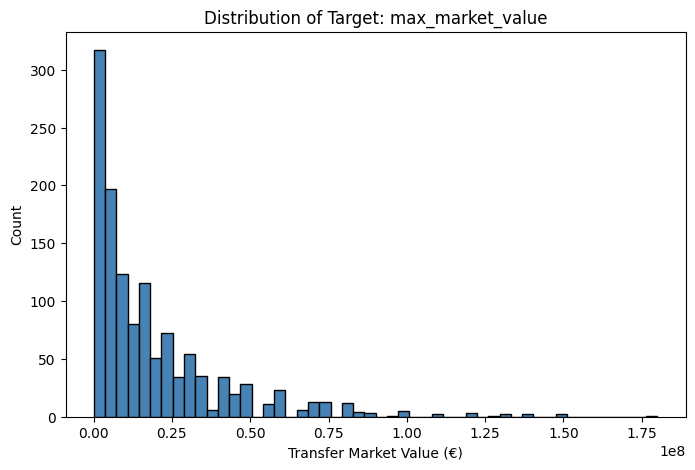

In [3]:
t = df[TARGET_COL]

print("\nTarget column summary:")
print(t.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))

# Count NaN + negatives
n_nan = t.isna().sum()
n_neg = (t < 0).sum()
print(f"\nNaNs in target: {n_nan},  Negatives in target: {n_neg}")

# Distribution plot
plt.figure(figsize=(8, 5))
plt.hist(t.dropna(), bins=50, color="steelblue", edgecolor="black")
plt.xlabel("Transfer Market Value (€)")
plt.ylabel("Count")
plt.title("Distribution of Target: max_market_value")
plt.show()


In [4]:

s = df[SEASON_COL]

print("\nSeason column info:")
print(s.describe())
print("Unique season values (sample):", sorted(s.unique())[:15])

# Check if season is numeric
if not np.issubdtype(s.dtype, np.number):
    print(f"Season dtype is {s.dtype}, trying to convert...")
    # Try converting if string like '2019/2020'
    try:
        df[SEASON_COL] = df[SEASON_COL].astype(str).str[:4].astype(int)
        print("Converted season to start-year integer.")
    except:
        print("Season conversion failed, manual inspection needed.")

# Check for NaNs and negatives
n_nan_season = df[SEASON_COL].isna().sum()
n_neg_season = (df[SEASON_COL] < 0).sum()
print(f"NaNs in season: {n_nan_season},  Negatives in season: {n_neg_season}")

# Check monotonic order per player
unordered_players = []
for pid, g in df.groupby(ID_COL):
    seasons = g[SEASON_COL].dropna().values
    if len(seasons) > 1 and not np.all(seasons[1:] >= seasons[:-1]):
        unordered_players.append(pid)

print(f"Players with unordered seasons: {len(unordered_players)}")
if unordered_players[:10]:
    print("Sample problematic player_ids:", unordered_players[:10])



Season column info:
count    1272.000000
mean     2022.137579
std         1.543730
min      2020.000000
25%      2020.000000
50%      2022.000000
75%      2024.000000
max      2024.000000
Name: season, dtype: float64
Unique season values (sample): [2020, 2022, 2023, 2024]
NaNs in season: 0,  Negatives in season: 0
Players with unordered seasons: 0


In [5]:

dupe_mask = df.duplicated(subset=[ID_COL, SEASON_COL], keep=False)
dupes = df[dupe_mask]

print(f"Total rows: {len(df)}")
print(f"Rows with duplicate (player_id, season): {len(dupes)}")
print(f"Unique players affected: {dupes[ID_COL].nunique()}")

if len(dupes) > 0:
    print("\nSample duplicate rows:")
    display(dupes.head(10))


Total rows: 1272
Rows with duplicate (player_id, season): 0
Unique players affected: 0


In [6]:

# 1) Sentiment features
print("\n--- Sentiment Features ---")
print(df[SENTIMENT_COLS].isna().sum())
print("Sample sentiment rows:")
display(df[SENTIMENT_COLS].head(5))

# 2) Injury features
print("\n--- Injury Features ---")
print(df[INJURY_COLS].isna().sum())

# 3) Performance features
print("\n--- Performance Features ---")
print(df[PERFORMANCE_COLS].isna().sum())

# 4) Rolling performance
print("\n--- Rolling Performance Features ---")
print(df[ROLLING_COLS].isna().sum())

# Quick rule check: sentiment ratios should not exceed 1
sent_sum = df["pos_ratio"].fillna(0) + df["neu_ratio"].fillna(0) + df["neg_ratio"].fillna(0)
violations = (sent_sum > 1.001).sum()
print(f"\nSentiment ratio sum > 1: {violations} rows")



--- Sentiment Features ---
num_posts               0
num_comments_used       0
pos_ratio             914
neu_ratio             914
neg_ratio             914
mean_compound         914
fallback_used           0
subreddits_covered    621
dtype: int64
Sample sentiment rows:


,num_posts,num_comments_used,pos_ratio,neu_ratio,neg_ratio,mean_compound,fallback_used,subreddits_covered
0,40,41,0.0,1.0,0.0,-0.411863,False,"laliga,ligue1,soccer"
1,0,0,NaN,NaN,NaN,NaN,True,NaN
2,0,0,NaN,NaN,NaN,NaN,True,NaN
3,16,16,NaN,NaN,NaN,NaN,True,soccer
4,24,22,0.0,1.0,0.0,-0.727373,False,"seriea,soccer"



--- Injury Features ---
injury_days                 1272
matches_missed              1272
injury_count                1272
avg_rating_before_injury    1272
avg_rating_after_injury     1272
rating_drop                 1272
dtype: int64

--- Performance Features ---
total_goals             965
total_assists           965
total_minutes_played    965
total_yellow_cards      965
total_red_cards         965
matches_played          965
dtype: int64

--- Rolling Performance Features ---
player_name_perf       0
total_goals_perf       0
total_assists_perf     0
shots_on_target        0
xG                     0
matches_played_perf    0
minutes_played         0
dtype: int64

Sentiment ratio sum > 1: 0 rows


In [7]:

df_clean = df.copy()

# --- Target ---
# Drop rows with NaN in target
df_clean = df_clean.dropna(subset=[TARGET_COL])

# --- Sentiment ---
for col in ["pos_ratio", "neu_ratio", "neg_ratio", "mean_compound", "subreddits_covered"]:
    df_clean[col + "_missing"] = df_clean[col].isna().astype(int)  # add missing indicator
    df_clean[col] = df_clean[col].fillna(0)  # fill missing with neutral/zero

# --- Injuries ---
for col in INJURY_COLS:
    df_clean[col] = df_clean[col].fillna(0)  # assume no injury if missing

# --- Performance ---
for col in PERFORMANCE_COLS:
    df_clean[col + "_missing"] = df_clean[col].isna().astype(int)  # add missing indicator
    df_clean[col] = df_clean[col].fillna(0)

# --- Sanity Check ---
print("Remaining NaNs per column (top 20):")
print(df_clean.isna().sum().sort_values(ascending=False).head(20))

print("\nDataset shape after cleaning:", df_clean.shape)
display(df_clean.head(3))


Remaining NaNs per column (top 20):
last_transfer_premium       932
avg_transfer_premium        932
last_transfer_fee           931
avg_transfer_fee            931
last_transfer_club_from     911
last_transfer_club_to       911
num_transfers               911
agent_name                  335
contract_expiration_date     84
country_of_birth             17
country_of_citizenship       16
foot                          2
Right Center Forward          1
Left Wing                     1
Right Center Midfield         1
Right Defensive Midfield      1
Right Center Back             1
Right Back                    1
Right Attacking Midfield      1
Left Wing Back                1
dtype: int64

Dataset shape after cleaning: (1271, 90)


,player_id,season,avg_market_value,max_market_value,min_market_value,player_name,num_transfers,avg_transfer_fee,last_transfer_fee,avg_transfer_premium,...,neu_ratio_missing,neg_ratio_missing,mean_compound_missing,subreddits_covered_missing,total_goals_missing,total_assists_missing,total_minutes_played_missing,total_yellow_cards_missing,total_red_cards_missing,matches_played_missing
0,123951,2022,4500000.0,5000000.0,4000000.0,aaron mooy,NaN,NaN,NaN,NaN,...,0,0,0,0,1,1,1,1,1,1
1,50057,2020,26250000.0,35000000.0,20000000.0,aaron ramsey,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,0,0,0
2,50057,2022,3000000.0,3000000.0,3000000.0,aaron ramsey,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1


In [8]:

import datetime as dt

df_clean2 = df_clean.copy()

# --- 1. Transfer features (numeric, keep and fill with 0) ---
transfer_numeric = ["last_transfer_premium", "avg_transfer_premium",
                    "last_transfer_fee", "avg_transfer_fee", "num_transfers"]
for col in transfer_numeric:
    df_clean2[col] = df_clean2[col].fillna(0)

# --- 2. Contract expiration date -> years remaining ---
# Convert to datetime, then compute years left (from a reference year, e.g., season year)
today_year = dt.datetime.now().year
df_clean2["contract_expiration_date"] = pd.to_datetime(
    df_clean2["contract_expiration_date"], errors="coerce"
)

df_clean2["contract_year_remaining"] = (
        df_clean2["contract_expiration_date"].dt.year.fillna(today_year) - df_clean2[SEASON_COL]
)
df_clean2["contract_year_remaining"] = df_clean2["contract_year_remaining"].clip(lower=0)  # no negatives

# Drop raw contract_expiration_date
df_clean2 = df_clean2.drop(columns=["contract_expiration_date"])

# --- 3. Foot (categorical -> one-hot, keep missing as "__MISSING__") ---
df_clean2["foot"] = df_clean2["foot"].fillna("__MISSING__")
foot_dummies = pd.get_dummies(df_clean2["foot"], prefix="foot")
df_clean2 = pd.concat([df_clean2.drop(columns=["foot"]), foot_dummies], axis=1)

# --- 4. Position one-hots (fill NaN -> 0) ---
for col in POS_ONEHOT_COLS:
    df_clean2[col] = df_clean2[col].fillna(0)

# --- 5. Drop sparse / high-cardinality categorical features ---
drop_cols = ["last_transfer_club_from", "last_transfer_club_to",
             "agent_name", "country_of_birth", "country_of_citizenship"]
df_clean2 = df_clean2.drop(columns=drop_cols, errors="ignore")

# --- 6. Club prestige score (optional reintroduction) ---
# Idea: prestige = frequency of club in dataset (proxy for visibility)
club_counts = df_clean["current_club_name"].value_counts()
df_clean2["club_prestige_score"] = df_clean2["current_club_name"].map(club_counts)
df_clean2["club_prestige_score"] = df_clean2["club_prestige_score"].fillna(0)

# Drop raw current_club_name/id if not needed
df_clean2 = df_clean2.drop(columns=["current_club_name", "current_club_id"], errors="ignore")

# --- 7. Sanity Check ---
print("Remaining NaNs after full cleaning:", df_clean2.isna().sum().sum())
print("Final dataset shape:", df_clean2.shape)
display(df_clean2.head(3))


Remaining NaNs after full cleaning: 0
Final dataset shape: (1271, 87)


,player_id,season,avg_market_value,max_market_value,min_market_value,player_name,num_transfers,avg_transfer_fee,last_transfer_fee,avg_transfer_premium,...,total_minutes_played_missing,total_yellow_cards_missing,total_red_cards_missing,matches_played_missing,contract_year_remaining,foot___MISSING__,foot_both,foot_left,foot_right,club_prestige_score
0,123951,2022,4500000.0,5000000.0,4000000.0,aaron mooy,0.0,0.0,0.0,0.0,...,1,1,1,1,3.0,False,False,False,True,14
1,50057,2020,26250000.0,35000000.0,20000000.0,aaron ramsey,0.0,0.0,0.0,0.0,...,0,0,0,0,5.0,False,False,False,True,7
2,50057,2022,3000000.0,3000000.0,3000000.0,aaron ramsey,0.0,0.0,0.0,0.0,...,1,1,1,1,3.0,False,False,False,True,7


In [14]:
dupes = df_clean2.columns[df_clean2.columns.duplicated()].tolist()
if dupes:
    print("Duplicate columns found:", dupes)
    df_clean2 = df_clean2.loc[:, ~df_clean2.columns.duplicated()]
    print("Dropped duplicates. Shape now:", df_clean2.shape)
else:
    print("No duplicate columns")


No duplicate columns


In [15]:
# Add subreddit coverage count (numeric feature)
if "subreddits_covered" in df_clean2.columns:
    df_clean2["subreddits_covered"] = df_clean2["subreddits_covered"].astype(str)
    df_clean2["subreddits_covered"] = df_clean2["subreddits_covered"].replace("0", "")
    df_clean2["subreddits_count"] = df_clean2["subreddits_covered"].apply(
        lambda x: 0 if x.strip() == "" else len(x.split(","))
    )

print("Added subreddits_count feature")
print(df_clean2[["subreddits_covered", "subreddits_count"]].head(10))


Added subreddits_count feature
     subreddits_covered  subreddits_count
0  laliga,ligue1,soccer                 3
1                                       0
2                                       0
3                soccer                 1
4         seriea,soccer                 2
5     bundesliga,soccer                 2
6     bundesliga,soccer                 2
7                soccer                 1
8         ligue1,soccer                 2
9                soccer                 1


In [17]:

# Save the cleaned dataset (unscaled)
DATA_PATH = os.path.join(PROJECT_PATH, "Data_Featuring")
# Ensure directory exists
os.makedirs(DATA_PATH, exist_ok=True)

# Drop redundant columns before saving
drop_cols = ["player_name_norm", "player_name_perf", "last_season"]
df_clean3 = df_clean2.drop(columns=[c for c in drop_cols if c in df_clean2.columns])

# Save the cleaned dataset (unscaled) to CSV
csv_path = os.path.join(DATA_PATH, "features_clean.csv")
df_clean3.to_csv(csv_path, index=False)

print("Saved clean dataset to:", csv_path)
print("Shape:", df_clean3.shape)
print("Columns:", len(df_clean3.columns))
print("Dropped redundant columns:", [c for c in drop_cols if c in df_clean2.columns])
display(df_clean3.head(5))


Saved clean dataset to: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Data_Featuring\features_clean.csv
Shape: (1271, 85)
Columns: 85
Dropped redundant columns: ['player_name_norm', 'player_name_perf', 'last_season']


,player_id,season,avg_market_value,max_market_value,min_market_value,player_name,num_transfers,avg_transfer_fee,last_transfer_fee,avg_transfer_premium,...,total_yellow_cards_missing,total_red_cards_missing,matches_played_missing,contract_year_remaining,foot___MISSING__,foot_both,foot_left,foot_right,club_prestige_score,subreddits_count
0,123951,2022,4.500000e+06,5000000.0,4000000.0,aaron mooy,0.0,0.000000,0.0,0.000000e+00,...,1,1,1,3.0,False,False,False,True,14,3
1,50057,2020,2.625000e+07,35000000.0,20000000.0,aaron ramsey,0.0,0.000000,0.0,0.000000e+00,...,0,0,0,5.0,False,False,False,True,7,0
2,50057,2022,3.000000e+06,3000000.0,3000000.0,aaron ramsey,0.0,0.000000,0.0,0.000000e+00,...,1,1,1,3.0,False,False,False,True,7,0
3,243633,2023,3.833333e+05,450000.0,350000.0,aaron tshibola,1.0,200000.000000,200000.0,-1.500000e+05,...,1,1,1,2.0,False,False,False,True,1,1
4,340394,2022,3.333333e+06,4000000.0,3000000.0,abdelhamid sabiri,3.0,333333.333333,1000000.0,-2.333333e+06,...,1,1,1,4.0,False,False,False,True,6,2


In [19]:
import joblib
from sklearn.preprocessing import StandardScaler

# Convert boolean categorical columns to int (0/1)
bool_cols = ["fallback_used", "foot___MISSING__", "foot_both", "foot_left", "foot_right"]
for col in bool_cols:
    if col in df_clean3.columns:
        df_clean3[col] = df_clean3[col].astype(int)
print("Converted boolean cols to int:", [col for col in bool_cols if col in df_clean3.columns])

# Exclude columns from scaling
exclude_cols = [
    ID_COL, SEASON_COL, TARGET_COL,
    "player_name", "date_of_birth", "sub_position", "position", "subreddits_covered"
]
exclude_cols += [c for c in df_clean3.columns if c.startswith("foot_")]
exclude_cols += POS_ONEHOT_COLS
exclude_cols += bool_cols  # make sure boolean cols stay excluded

# Identify numeric features (this already includes subreddits_count)
numeric_cols = [c for c in df_clean3.columns
                if c not in exclude_cols and df_clean3[c].dtype != "object"]

print("Total numeric cols to scale:", len(numeric_cols))
print("Example numeric cols:", numeric_cols[:10])

# Scale numeric features
scaler = StandardScaler()
df_scaled = df_clean3.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_clean3[numeric_cols])

# Save paths
raw_path = os.path.join(DATA_PATH, "features_raw.parquet")
scaled_path = os.path.join(DATA_PATH, "features_scaled.parquet")
scaler_path = os.path.join(DATA_PATH, "scaler.joblib")

df_clean3.to_parquet(raw_path, index=False)
df_scaled.to_parquet(scaled_path, index=False)
joblib.dump(scaler, scaler_path)

print("Saved raw features to:", raw_path)
print("Saved scaled features to:", scaled_path)
print("Saved scaler to:", scaler_path)

# Quick sanity check
means = df_scaled[numeric_cols].mean().round(2)
stds = df_scaled[numeric_cols].std().round(2)
print("\nMean of scaled features (should be ~0):", means.mean())
print("Std of scaled features (should be ~1):", stds.mean())

display(df_clean3[["subreddits_covered", "subreddits_count"]].head(10))


Converted boolean cols to int: ['fallback_used', 'foot___MISSING__', 'foot_both', 'foot_left', 'foot_right']
Total numeric cols to scale: 47
Example numeric cols: ['avg_market_value', 'min_market_value', 'num_transfers', 'avg_transfer_fee', 'last_transfer_fee', 'avg_transfer_premium', 'last_transfer_premium', 'total_goals', 'total_assists', 'total_minutes_played']
Saved raw features to: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Data_Featuring\features_raw.parquet
Saved scaled features to: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Data_Featuring\features_scaled.parquet
Saved scaler to: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Data_Featuring\scaler.joblib

Mean of scaled features (should be ~0): 0.0
Std of scaled features (should be ~1): 0.851063829787234


,subreddits_covered,subreddits_count
0,"laliga,ligue1,soccer",3
1,,0
2,,0
3,soccer,1
4,"seriea,soccer",2
5,"bundesliga,soccer",2
6,"bundesliga,soccer",2
7,soccer,1
8,"ligue1,soccer",2
9,soccer,1


### Feature engineering + features_clean.csv + features_raw.parquet + features_scaled.parquet and scaler.joblib is obtained.